In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pytorch-msssim

In [3]:
# DnCNN Model Definition, Data Prep, and Training Loop for Colab
"""
Define, inspect, prepare data, and train the DnCNN denoiser interactively in a Colab notebook.
Includes utilities for computing dataset statistics, loading from ZIPs, and a basic train/val loop
that tracks both MSE loss and SSIM.
"""
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import DataLoader
import zipfile, io
from PIL import Image
from tqdm import tqdm
import math
from pathlib import Path
# For SSIM calculation
from pytorch_msssim import ssim
import os

In [4]:
# ---------------------------------------------
# 1. DnCNN Definition and Inspection
# ---------------------------------------------
class DnCNN(nn.Module):
    """
    Denoising CNN that predicts noise and subtracts it from input.
    """
    def __init__(self, in_channels=1, num_layers=17, num_features=64):
        super().__init__()
        layers = []
        # Initial conv + ReLU
        layers.append(nn.Conv2d(in_channels, num_features, kernel_size=3, padding=1, bias=True))
        layers.append(nn.ReLU(inplace=True))
        # Hidden blocks: conv + batchnorm + ReLU
        for _ in range(num_layers - 2):
            layers.append(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(num_features))
            layers.append(nn.ReLU(inplace=True))
        # Final conv predicts noise
        layers.append(nn.Conv2d(num_features, in_channels, kernel_size=3, padding=1, bias=False))
        # Use attribute 'model' for consistency
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.model(x)
        return x - noise


In [5]:
def inspect_dncnn(in_channels=1, num_layers=17, img_size=(256, 256), batch_size=1):
    """
    Print model summary and layer shapes on a dummy input.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DnCNN(in_channels, num_layers).to(device)
    print(f"Building DnCNN: layers={num_layers}, features={model.model[0].out_channels}, in_channels={in_channels}")
    summary(model, (in_channels, *img_size), batch_size=batch_size, device=device.type)

    # Layer-by-layer shape tracing
    x = torch.zeros(batch_size, in_channels, *img_size, device=device)
    print("\nLayer-by-layer shapes:")
    out = x
    for idx, layer in enumerate(model.model, 1):
        out = layer(out)
        print(f"Layer {idx:02d}: {layer.__class__.__name__} -> {tuple(out.shape)}")

In [6]:
def compute_mean_std(zip_path):
    zf = zipfile.ZipFile(zip_path,'r')
    imgs = [f for f in zf.namelist() if f.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff'))]
    sum_m, sum_v, cnt = 0.0,0.0,0
    for f in tqdm(imgs, desc=f"Stats {zip_path}"):
        with zf.open(f) as fp:
            img = Image.open(io.BytesIO(fp.read())).convert('L')
        t = transforms.ToTensor()(img)
        sum_m += t.mean().item(); sum_v += t.var(unbiased=False).item(); cnt+=1
    mean = sum_m/cnt; std = math.sqrt(sum_v/cnt)
    return mean, std

def compute_all_stats(zips):
    stats={}
    for p in zips:
        m,s=compute_mean_std(p); print(f"{p}: mean={m:.4f}, std={s:.4f}"); stats[p]=(m,s)
    return stats

In [ ]:
stats = compute_all_stats([
    '/content/drive/MyDrive/IA2/dataset/train_clean.zip',
    '/content/drive/MyDrive/IA2/dataset/val_clean.zip',
    '/content/drive/MyDrive/IA2/dataset/test_clean.zip'
])

Stats /content/drive/MyDrive/IA2/dataset/train_clean.zip: 100%|██████████| 6000/6000 [00:08<00:00, 691.39it/s]


/content/drive/MyDrive/IA2/dataset/train_clean.zip: mean=0.1781, std=0.1976


Stats /content/drive/MyDrive/IA2/dataset/val_clean.zip: 100%|██████████| 2000/2000 [00:03<00:00, 524.28it/s]


/content/drive/MyDrive/IA2/dataset/val_clean.zip: mean=0.1799, std=0.1984


Stats /content/drive/MyDrive/IA2/dataset/test_clean.zip: 100%|██████████| 2000/2000 [00:03<00:00, 608.79it/s]

/content/drive/MyDrive/IA2/dataset/test_clean.zip: mean=0.1779, std=0.1971


In [ ]:
inspect_dncnn(in_channels=1, num_layers=17, img_size=(256,256), batch_size=1)

Building DnCNN: layers=17, features=64, in_channels=1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 256, 256]             640
              ReLU-2          [1, 64, 256, 256]               0
            Conv2d-3          [1, 64, 256, 256]          36,864
       BatchNorm2d-4          [1, 64, 256, 256]             128
              ReLU-5          [1, 64, 256, 256]               0
            Conv2d-6          [1, 64, 256, 256]          36,864
       BatchNorm2d-7          [1, 64, 256, 256]             128
              ReLU-8          [1, 64, 256, 256]               0
            Conv2d-9          [1, 64, 256, 256]          36,864
      BatchNorm2d-10          [1, 64, 256, 256]             128
             ReLU-11          [1, 64, 256, 256]               0
           Conv2d-12          [1, 64, 256, 256]          36,864
      BatchNorm2d-13          [1, 64, 256, 256]  

In [12]:
# ---------------------------------------------
# 3. Transforms with Resize
# ---------------------------------------------
# Use stats from train_clean.zip
mean, std = [0.1781], [0.1976]
# Target resolution
target_size = (256, 256)

train_tf = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
val_tf = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [7]:
import zipfile, io
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [8]:
# ---------------------------------------------
# 4. ZIP Dataset Loader
# ---------------------------------------------
class PairedZipDataset(torch.utils.data.Dataset):
    """
    Reads paired clean/noisy images directly from ZIP archives.
    Lazily opens ZIP files per worker and matches on basenames in 'clean/' and 'noisy/' folders.
    """
    def __init__(self, clean_zip, noisy_zip, transform=None):
        self.clean_zip_path = clean_zip
        self.noisy_zip_path = noisy_zip
        # List all clean/ filenames once
        with zipfile.ZipFile(self.clean_zip_path) as zc:
            self.fnames = sorted(
                Path(f).name
                for f in zc.namelist()
                if f.startswith("clean/") and f.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff'))
            )
        self.transform = transform or (lambda x: x)
        # placeholders for per-worker zipfile handles
        self.zc = None
        self.zn = None

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        # lazily open archives per worker
        if self.zc is None:
            self.zc = zipfile.ZipFile(self.clean_zip_path)
        if self.zn is None:
            self.zn = zipfile.ZipFile(self.noisy_zip_path)

        fname = self.fnames[idx]
        clean_path = f"clean/{fname}"
        noisy_path = f"noisy/{fname}"

        # Read and decode images
        data_c = self.zc.read(clean_path)
        data_n = self.zn.read(noisy_path)
        img_c = Image.open(io.BytesIO(data_c)).convert('L')
        img_n = Image.open(io.BytesIO(data_n)).convert('L')

        # Apply transforms
        return self.transform(img_n), self.transform(img_c)

In [9]:
----------------------------------------
# 4. Training Loop & Scheduler
# ---------------------------------------------

def train_model(model,train_loader,val_loader,epochs=40,lr=1e-3,pat=5,chk='ckpt'):
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    opt=torch.optim.Adam(model.parameters(),lr=lr)
    sched=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',factor=0.5,patience=3,verbose=True)
    os.makedirs(chk,exist_ok=True)
    best=float('inf');cnt=0
    for e in range(1,epochs+1):
        print(f'Epoch {e}/{epochs}')
        model.train();tloss=0;ssum=0
        for batch_idx, (X,Y) in enumerate(tqdm(train_loader, desc='Train', leave=False)):
            X, Y = X.to(device), Y.to(device)
            P = model(X)
            # Debug prints for first batch of epoch 1
            if batch_idx == 0 and e == 1:
                print(f"DEBUG RDUNet Epoch1 Batch1 - Input: min={X.min().item():.4f}, max={X.max().item():.4f}, mean={X.mean().item():.4f}")
                print(f"DEBUG RDUNet Epoch1 Batch1 - Pred: min={P.min().item():.4f}, max={P.max().item():.4f}, mean={P.mean().item():.4f}")
                print(f"DEBUG RDUNet Epoch1 Batch1 - Target: min={Y.min().item():.4f}, max={Y.max().item():.4f}, mean={Y.mean().item():.4f}")
            loss = F.mse_loss(P, Y)(P, Y)
            opt.zero_grad();loss.backward();opt.step()
            tloss+=loss.item()*X.size(0)
            ssum+= ssim(P,Y,data_range=1.0,size_average=True).item()*X.size(0)
        tloss/=len(train_loader.dataset)
        tss=ssum/len(train_loader.dataset)
        model.eval();vloss=0;vssm=0;ps=0
        with torch.no_grad():
            for X,Y in tqdm(val_loader,desc='Val',leave=False):
                X,Y=X.to(device),Y.to(device)
                P=model(X)
                vloss+=F.mse_loss(P,Y).item()*X.size(0)
                vssm+=ssim(P,Y,data_range=1.0,size_average=True).item()*X.size(0)
                m=(P-Y).pow(2).mean().item()
                ps+=10*math.log10(1.0/m)*X.size(0)
        vloss/=len(val_loader.dataset)
        vss=vssm/len(val_loader.dataset)
        vps=ps/len(val_loader.dataset)
        print(f'Train MSE={tloss:.4f}, SSIM={tss:.4f} | Val MSE={vloss:.4f}, SSIM={vss:.4f}, PSNR={vps:.2f}dB')
        sched.step(vloss)
        if vloss<best: torch.save(model.state_dict(),f'{chk}/best_e{e}.pth');best=vloss;cnt=0
        else: cnt+=1;print(f'No imp {cnt}/{pat}')
        if cnt>=pat: print('Early stop');break

In [10]:
def collate_fn(batch):
    """
    Custom collate_fn to stack paired tensors without storage resize issues.
    """
    noisy_list, clean_list = zip(*batch)
    return torch.stack(noisy_list, 0), torch.stack(clean_list, 0)


In [ ]:
# ---------------------------------------------
# 6. DataLoader & Training Example
# ---------------------------------------------
# Instantiate datasets and loaders
# Instantiate datasets
train_ds = PairedZipDataset(
    clean_zip='/content/drive/MyDrive/IA2/dataset/train_clean.zip',
    noisy_zip='/content/drive/MyDrive/IA2/dataset/train_noisy.zip',
    transform=train_tf
)
val_ds = PairedZipDataset(
    clean_zip='/content/drive/MyDrive/IA2/dataset/val_clean.zip',
    noisy_zip='/content/drive/MyDrive/IA2/dataset/val_noisy.zip',
    transform=val_tf
)

# Create loaders with custom collate_fn
train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [ ]:
print("Train set size:", len(train_loader.dataset))
print("Val   set size:", len(val_loader.dataset))


Train set size: 6000
Val   set size: 2000


In [ ]:
noisy, clean = next(iter(train_loader))
print("One batch shapes:", noisy.shape, clean.shape)


One batch shapes: torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


In [ ]:
# Create model and start training
model = DnCNN(in_channels=1, num_layers=17)
# Suggest starting with 25-30 epochs; you can increase to 50 if metrics continue improving, but
# consider adding early stopping or monitoring validation PSNR/SSIM to avoid overfitting.
train_model(model, train_loader, val_loader, epochs=50, lr=1e-3, patience=5, checkpoint_dir='checkpoints')

>>> train_model called: epochs=50, lr=0.001, patience=5
--- Starting Epoch 1/50 ---


Epoch 1/50: Train MSE=0.1025, Train SSIM=0.4611 | Val MSE=0.0887, Val SSIM=0.4879, Val PSNR=10.99dB
  Saved checkpoint: checkpoints/best_ep1.pth
--- Starting Epoch 2/50 ---


Epoch 2/50: Train MSE=0.0836, Train SSIM=0.5239 | Val MSE=0.0759, Val SSIM=0.5450, Val PSNR=11.66dB
  Saved checkpoint: checkpoints/best_ep2.pth
--- Starting Epoch 3/50 ---


Epoch 3/50: Train MSE=0.0736, Train SSIM=0.5623 | Val MSE=0.0654, Val SSIM=0.5670, Val PSNR=12.25dB
  Saved checkpoint: checkpoints/best_ep3.pth
--- Starting Epoch 4/50 ---


Epoch 4/50: Train MSE=0.0671, Train SSIM=0.5857 | Val MSE=0.0580, Val SSIM=0.6047, Val PSNR=12.90dB
  Saved checkpoint: checkpoints/best_ep4.pth
--- Starting Epoch 5/50 ---


Epoch 5/50: Train MSE=0.0611, Train SSIM=0.6019 | Val MSE=0.0545, Val SSIM=0.6183, Val PSNR=13.20dB
  Saved checkpoint: checkpoints/best_ep5.pth
--- Starting Epoch 6/50 ---


Epoch 6/50: Train MSE=0.0565, Train SSIM=0.6132 | Val MSE=0.0495, Val SSIM=0.6378, Val PSNR=13.56dB
  Saved checkpoint: checkpoints/best_ep6.pth
--- Starting Epoch 7/50 ---


Epoch 7/50: Train MSE=0.0510, Train SSIM=0.6259 | Val MSE=0.0567, Val SSIM=0.6098, Val PSNR=12.96dB
--- Starting Epoch 8/50 ---


Epoch 8/50: Train MSE=0.0485, Train SSIM=0.6338 | Val MSE=0.0691, Val SSIM=0.5800, Val PSNR=12.20dB
--- Starting Epoch 9/50 ---


Epoch 9/50: Train MSE=0.0449, Train SSIM=0.6425 | Val MSE=0.0428, Val SSIM=0.6435, Val PSNR=14.18dB
  Saved checkpoint: checkpoints/best_ep9.pth
--- Starting Epoch 10/50 ---


Epoch 10/50: Train MSE=0.0427, Train SSIM=0.6503 | Val MSE=0.0433, Val SSIM=0.6305, Val PSNR=14.10dB
--- Starting Epoch 11/50 ---


Epoch 11/50: Train MSE=0.0409, Train SSIM=0.6580 | Val MSE=0.0464, Val SSIM=0.6245, Val PSNR=13.94dB
--- Starting Epoch 12/50 ---


Epoch 12/50: Train MSE=0.0402, Train SSIM=0.6619 | Val MSE=0.0428, Val SSIM=0.6270, Val PSNR=14.10dB
  Saved checkpoint: checkpoints/best_ep12.pth
--- Starting Epoch 13/50 ---


Epoch 13/50: Train MSE=0.0387, Train SSIM=0.6659 | Val MSE=0.0356, Val SSIM=0.6817, Val PSNR=15.06dB
  Saved checkpoint: checkpoints/best_ep13.pth
--- Starting Epoch 14/50 ---


Epoch 14/50: Train MSE=0.0375, Train SSIM=0.6709 | Val MSE=0.0360, Val SSIM=0.6664, Val PSNR=14.96dB
--- Starting Epoch 15/50 ---


Epoch 15/50: Train MSE=0.0361, Train SSIM=0.6770 | Val MSE=0.0340, Val SSIM=0.6932, Val PSNR=15.35dB
  Saved checkpoint: checkpoints/best_ep15.pth
--- Starting Epoch 16/50 ---


Epoch 16/50: Train MSE=0.0358, Train SSIM=0.6789 | Val MSE=0.0360, Val SSIM=0.6858, Val PSNR=15.01dB
--- Starting Epoch 17/50 ---


Epoch 17/50: Train MSE=0.0346, Train SSIM=0.6858 | Val MSE=0.0345, Val SSIM=0.6928, Val PSNR=15.39dB
--- Starting Epoch 18/50 ---


Epoch 18/50: Train MSE=0.0342, Train SSIM=0.6869 | Val MSE=0.0360, Val SSIM=0.6843, Val PSNR=15.00dB
--- Starting Epoch 19/50 ---


Epoch 19/50: Train MSE=0.0338, Train SSIM=0.6897 | Val MSE=0.0414, Val SSIM=0.6775, Val PSNR=14.51dB
--- Starting Epoch 20/50 ---


Epoch 20/50: Train MSE=0.0332, Train SSIM=0.6926 | Val MSE=0.0346, Val SSIM=0.6928, Val PSNR=15.16dB
Early stopping at epoch 20


In [ ]:
import shutil
import os

# Define source and destination paths
src_path = '/content/checkpoints'
dst_path = '/content/drive/MyDrive/IA2/dncnn_checkpoints'

# Ensure the destination directory exists
os.makedirs(dst_path, exist_ok=True)

# Copy the entire directory
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

print(f"Checkpoints copied from {src_path} to {dst_path}")


Checkpoints copied from /content/checkpoints to /content/drive/MyDrive/IA2/dncnn_checkpoints


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/IA2/dncnn_checkpoints/best_ep15.pth'))
train_model(model, train_loader, val_loader,
            epochs=20,    # additional epochs
            lr=1e-4,      # lowered LR
            patience=5,   # same or reduced patience
            checkpoint_dir='checkpoints_finetune')


>>> train_model called: epochs=20, lr=0.0001, patience=5
--- Starting Epoch 1/20 ---


Epoch 1/20: Train MSE=0.0310, Train SSIM=0.6984 | Val MSE=0.0303, Val SSIM=0.7029, Val PSNR=15.82dB
  Saved checkpoint: checkpoints_finetune/best_ep1.pth
--- Starting Epoch 2/20 ---


Epoch 2/20: Train MSE=0.0304, Train SSIM=0.6994 | Val MSE=0.0297, Val SSIM=0.7076, Val PSNR=15.89dB
  Saved checkpoint: checkpoints_finetune/best_ep2.pth
--- Starting Epoch 3/20 ---


Epoch 3/20: Train MSE=0.0299, Train SSIM=0.7017 | Val MSE=0.0293, Val SSIM=0.7091, Val PSNR=15.99dB
  Saved checkpoint: checkpoints_finetune/best_ep3.pth
--- Starting Epoch 4/20 ---


Epoch 4/20: Train MSE=0.0297, Train SSIM=0.7026 | Val MSE=0.0292, Val SSIM=0.7103, Val PSNR=15.98dB
  Saved checkpoint: checkpoints_finetune/best_ep4.pth
--- Starting Epoch 5/20 ---


Epoch 5/20: Train MSE=0.0295, Train SSIM=0.7043 | Val MSE=0.0291, Val SSIM=0.7115, Val PSNR=16.03dB
  Saved checkpoint: checkpoints_finetune/best_ep5.pth
--- Starting Epoch 6/20 ---


Epoch 6/20: Train MSE=0.0293, Train SSIM=0.7052 | Val MSE=0.0288, Val SSIM=0.7140, Val PSNR=16.05dB
  Saved checkpoint: checkpoints_finetune/best_ep6.pth
--- Starting Epoch 7/20 ---


Epoch 7/20: Train MSE=0.0292, Train SSIM=0.7060 | Val MSE=0.0285, Val SSIM=0.7149, Val PSNR=16.10dB
  Saved checkpoint: checkpoints_finetune/best_ep7.pth
--- Starting Epoch 8/20 ---


Epoch 8/20: Train MSE=0.0290, Train SSIM=0.7074 | Val MSE=0.0285, Val SSIM=0.7159, Val PSNR=16.11dB
  Saved checkpoint: checkpoints_finetune/best_ep8.pth
--- Starting Epoch 9/20 ---


Epoch 9/20: Train MSE=0.0289, Train SSIM=0.7086 | Val MSE=0.0284, Val SSIM=0.7172, Val PSNR=16.11dB
  Saved checkpoint: checkpoints_finetune/best_ep9.pth
--- Starting Epoch 10/20 ---


Epoch 10/20: Train MSE=0.0286, Train SSIM=0.7085 | Val MSE=0.0283, Val SSIM=0.7195, Val PSNR=16.16dB
  Saved checkpoint: checkpoints_finetune/best_ep10.pth
--- Starting Epoch 11/20 ---


Epoch 11/20: Train MSE=0.0285, Train SSIM=0.7101 | Val MSE=0.0285, Val SSIM=0.7145, Val PSNR=16.10dB
--- Starting Epoch 12/20 ---


Epoch 12/20: Train MSE=0.0285, Train SSIM=0.7093 | Val MSE=0.0283, Val SSIM=0.7152, Val PSNR=16.13dB
--- Starting Epoch 13/20 ---


Epoch 13/20: Train MSE=0.0283, Train SSIM=0.7117 | Val MSE=0.0279, Val SSIM=0.7208, Val PSNR=16.23dB
  Saved checkpoint: checkpoints_finetune/best_ep13.pth
--- Starting Epoch 14/20 ---


Epoch 14/20: Train MSE=0.0282, Train SSIM=0.7104 | Val MSE=0.0280, Val SSIM=0.7177, Val PSNR=16.18dB
--- Starting Epoch 15/20 ---


Epoch 15/20: Train MSE=0.0281, Train SSIM=0.7116 | Val MSE=0.0278, Val SSIM=0.7173, Val PSNR=16.20dB
  Saved checkpoint: checkpoints_finetune/best_ep15.pth
--- Starting Epoch 16/20 ---


Epoch 16/20: Train MSE=0.0278, Train SSIM=0.7140 | Val MSE=0.0281, Val SSIM=0.7205, Val PSNR=16.19dB
--- Starting Epoch 17/20 ---


Epoch 17/20: Train MSE=0.0278, Train SSIM=0.7138 | Val MSE=0.0274, Val SSIM=0.7235, Val PSNR=16.29dB
  Saved checkpoint: checkpoints_finetune/best_ep17.pth
--- Starting Epoch 18/20 ---


Epoch 18/20: Train MSE=0.0277, Train SSIM=0.7152 | Val MSE=0.0276, Val SSIM=0.7236, Val PSNR=16.24dB
--- Starting Epoch 19/20 ---


Epoch 19/20: Train MSE=0.0277, Train SSIM=0.7146 | Val MSE=0.0273, Val SSIM=0.7251, Val PSNR=16.30dB
  Saved checkpoint: checkpoints_finetune/best_ep19.pth
--- Starting Epoch 20/20 ---


Epoch 20/20: Train MSE=0.0276, Train SSIM=0.7151 | Val MSE=0.0276, Val SSIM=0.7243, Val PSNR=16.29dB


In [ ]:
import shutil
import os

# Define source and destination paths
src_path = '/content/checkpoints_finetune'
dst_path = '/content/drive/MyDrive/IA2/dncnn_checkpoints_finetune'

# Ensure the destination directory exists
os.makedirs(dst_path, exist_ok=True)

# Copy the entire directory
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

print(f"Checkpoints copied from {src_path} to {dst_path}")


Checkpoints copied from /content/checkpoints_finetune to /content/drive/MyDrive/IA2/dncnn_checkpoints_finetune


In [13]:
# ---------------------------------------------
# 7. Test Set Evaluation
# ---------------------------------------------
# Load best fine-tuned model checkpoint from Drive
best_ckpt = '/content/drive/MyDrive/IA2/dncnn_checkpoints_finetune/best_ep17.pth'
model = DnCNN(in_channels=1, num_layers=17)
model.load_state_dict(torch.load(best_ckpt, map_location='cpu'))
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Prepare test DataLoader
test_ds = PairedZipDataset('/content/drive/MyDrive/IA2/dataset/test_clean.zip', '/content/drive/MyDrive/IA2/dataset/test_noisy.zip', val_tf)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Metrics per-instance
all_mse = []
all_ssim = []
all_psnr = []

with torch.no_grad():
    for noisy, clean in tqdm(test_loader, desc='Testing'):
        noisy, clean = noisy.to(device), clean.to(device)
        pred = model(noisy)
        # per-image MSE
        per_mse = (pred - clean).pow(2).mean(dim=[1,2,3]).cpu().tolist()
        all_mse.extend(per_mse)
        # per-image SSIM
        batch_ssim = ssim(pred, clean, data_range=1.0, size_average=False)
        all_ssim.extend(batch_ssim.cpu().tolist())
        # per-image PSNR
        per_psnr = [10 * math.log10(1.0 / m) for m in per_mse]
        all_psnr.extend(per_psnr)

# Compute averages
test_mse = sum(all_mse) / len(all_mse)
test_ssim = sum(all_ssim) / len(all_ssim)
test_psnr = sum(all_psnr) / len(all_psnr)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test SSIM: {test_ssim:.4f}")
print(f"Test PSNR: {test_psnr:.2f} dB")

Testing: 100%|██████████| 250/250 [00:42<00:00,  5.94it/s]

Test MSE: 0.0266
Test SSIM: 0.7066
Test PSNR: 18.19 dB


In [14]:
# Optionally, save per-instance results for later analysis
import pandas as pd
results_df = pd.DataFrame({'mse': all_mse, 'ssim': all_ssim, 'psnr': all_psnr})
results_df.to_csv('test_results.csv', index=False)
print("Per-instance test results saved to test_results.csv")


Per-instance test results saved to test_results.csv


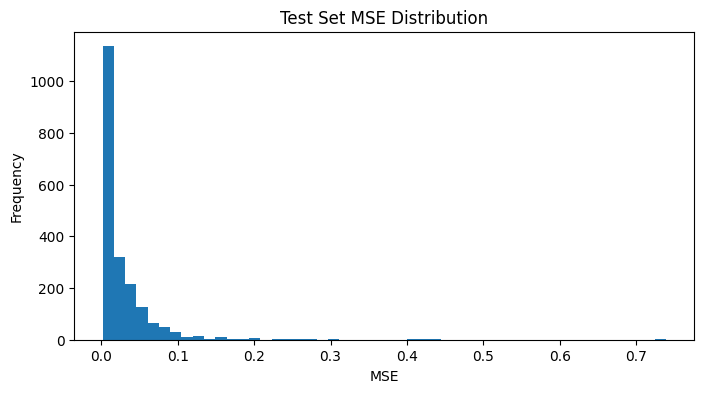

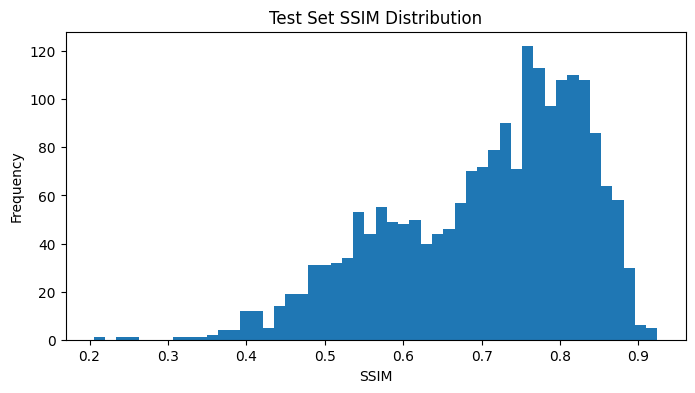

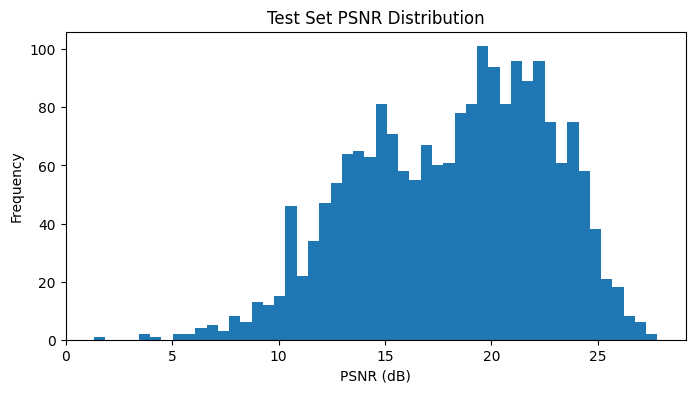

In [15]:
# ---------------------------------------------
# 8. Plot Histograms of Test Metrics
# ---------------------------------------------
import matplotlib.pyplot as plt

# Load or use the lists directly
# Plot MSE histogram
plt.figure(figsize=(8,4))
plt.hist(all_mse, bins=50)
plt.title('Test Set MSE Distribution')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()

# Plot SSIM histogram
plt.figure(figsize=(8,4))
plt.hist(all_ssim, bins=50)
plt.title('Test Set SSIM Distribution')
plt.xlabel('SSIM')
plt.ylabel('Frequency')
plt.show()

# Plot PSNR histogram
plt.figure(figsize=(8,4))
plt.hist(all_psnr, bins=50)
plt.title('Test Set PSNR Distribution')
plt.xlabel('PSNR (dB)')
plt.ylabel('Frequency')
plt.show()

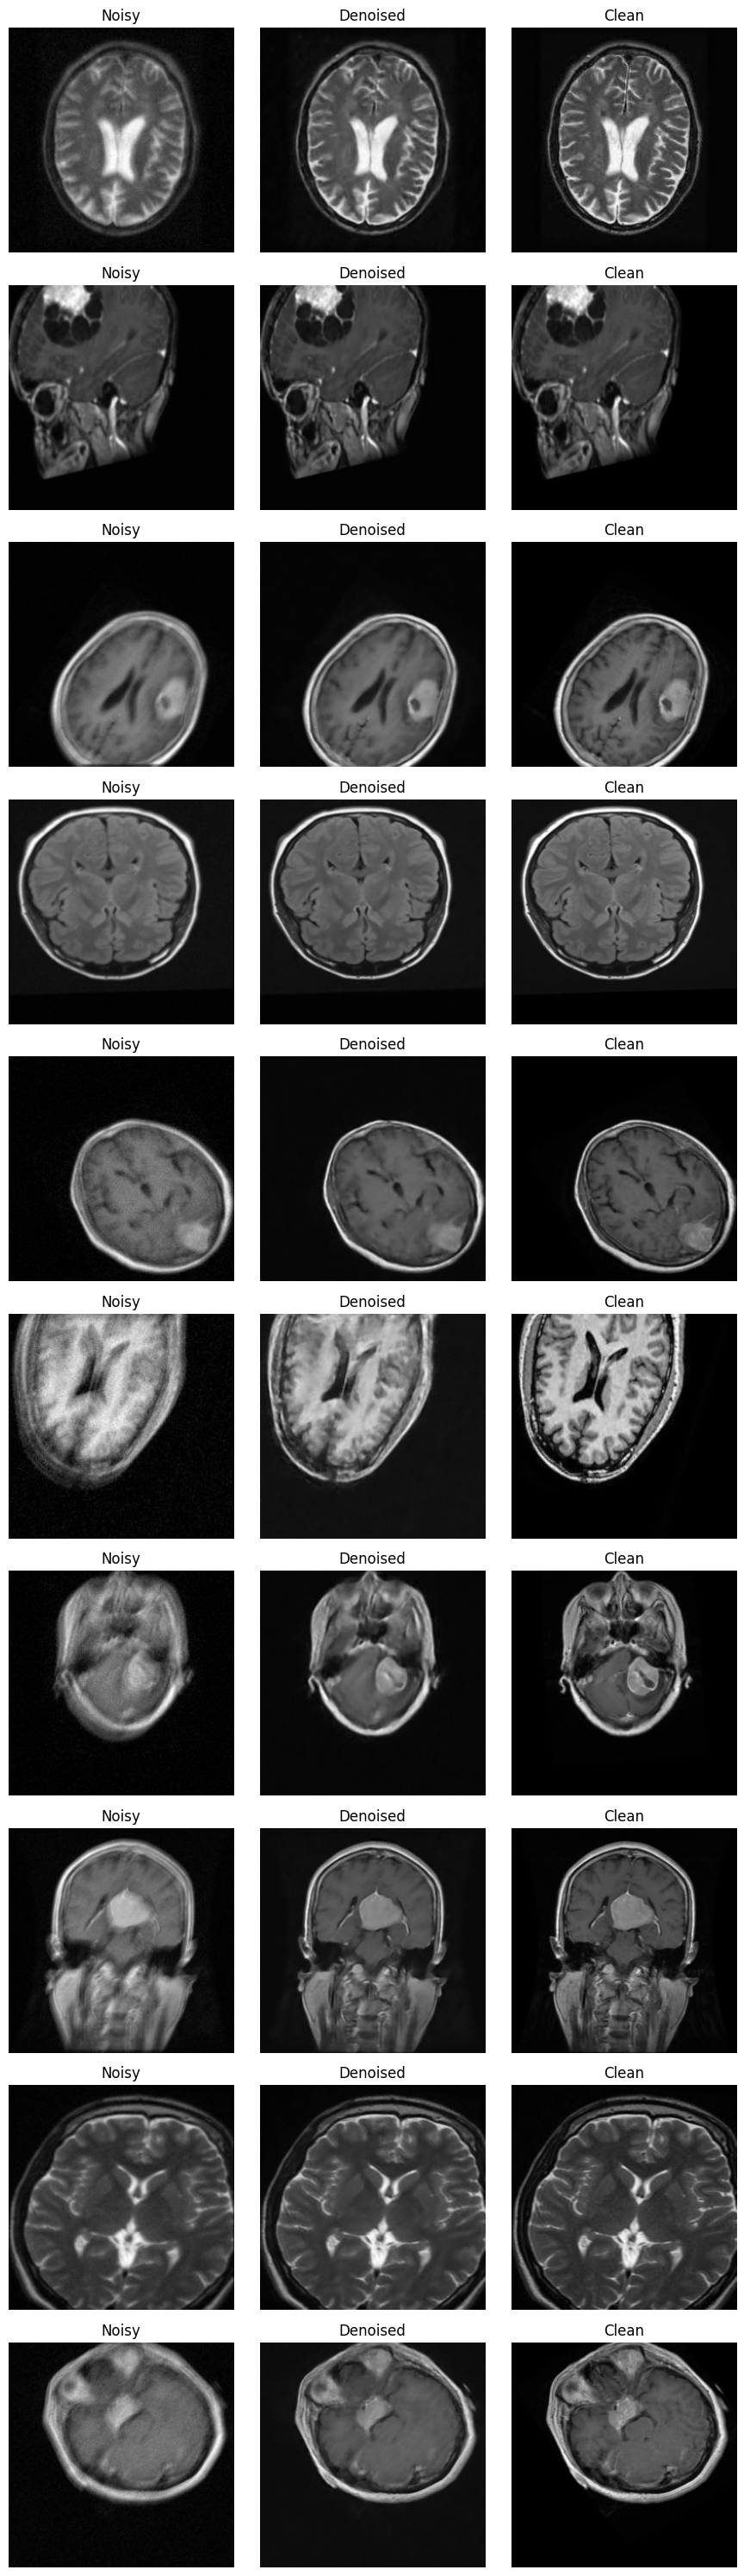

In [16]:
# ---------------------------------------------
# 9. Visualize Sample Denoising Results
# ---------------------------------------------
import random
# Select 10 random indices
indices = random.sample(range(len(test_ds)), 10)

# Prepare a figure with 3 columns: Noisy | Denoised | Clean
fig, axes = plt.subplots(10, 3, figsize=(9, 30))
for i, idx in enumerate(indices):
    noisy_img, clean_img = test_ds[idx]
    # Add batch dimension and send through model
    model.eval()
    with torch.no_grad():
        inp = noisy_img.unsqueeze(0).to(device)
        denoised = model(inp).squeeze(0).cpu()
    # Denormalize for display
    def denorm(t): return t * std[0] + mean[0]
    noisy_disp = denorm(noisy_img).squeeze().cpu().numpy()
    denoised_disp = denorm(denoised).squeeze().cpu().numpy()
    clean_disp = denorm(clean_img).squeeze().cpu().numpy()
    # Plot
    axes[i, 0].imshow(noisy_disp, cmap='gray'); axes[i, 0].axis('off');
    axes[i, 0].set_title('Noisy')
    axes[i, 1].imshow(denoised_disp, cmap='gray'); axes[i, 1].axis('off');
    axes[i, 1].set_title('Denoised')
    axes[i, 2].imshow(clean_disp, cmap='gray'); axes[i, 2].axis('off');
    axes[i, 2].set_title('Clean')
plt.tight_layout()
plt.show()